## Load data from file

In [1]:
import numpy as np

with open('rnn-challenge-data.npz', 'rb') as f:
    X = np.load(f)
    data_x = X['data_x']
    data_y = X['data_y']
    val_x = X['val_x']
    val_y = X['val_y']
    test_x = X['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# VALIDATION DATA: INPUT (x) AND OUTPUT (y)
print(val_x.shape, val_x.dtype)
print(val_y.shape, val_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

(400,) <U400
(400,) int64
(100,) <U1200
(100,) int64
(250,) <U2000


## Encode genome sequences

In [2]:
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import torch

def encode_genome_sequence(genome_sequence):
    # convert string to list of chars
    char_array =  np.array(list(genome_sequence))
    
    # encode characters using one-hot-encoding
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(char_array)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    # one hot encode
    onehot_encoder = OneHotEncoder(sparse=False)
    encoded=onehot_encoder.fit_transform(integer_encoded)
    return encoded
    
encoded_x = encode_genome_sequence(data_x[0])

## Custom Dataset for training

In [3]:
from torch.utils.data import Dataset

class CustomSequenceDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None, target_transform=None):
        self.sequences = x_data
        self.labels = y_data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sequence=self.sequences[idx]
        label=self.labels[idx]
        if self.transform:
            sequence = self.transform(sequence)
        if self.target_transform:
            label = self.target_transform(label,len(sequence))
        # make y as large as x 
        return sequence, label

## Create Dataloader for training

In [4]:
batch_size = 1

train_dataset=CustomSequenceDataset(data_x,data_y,transform = encode_genome_sequence)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size,shuffle=True)

## Create Dataloader for validation

In [5]:
test_dataset=CustomSequenceDataset(val_x,val_y,transform = encode_genome_sequence)
testloader = torch.utils.data.DataLoader(test_dataset, 1)
train_testloader = torch.utils.data.DataLoader(train_dataset,1)

## Check Data Format

In [6]:
# LSTM Layer expects the format (sequence_length,batch-size,feature_size) or (batch,sequence,feature) if param batch_first
x,y=next(iter(trainloader))
x.shape


torch.Size([1, 400, 4])

Ok, batch seems to be first, I'll set the parameter batch_first

## Define Model

In [7]:
from torch import nn
import torch.nn.functional as F

class LSTM(nn.Module):

    def __init__(self):
        super(LSTM, self).__init__()

        self.hidden_size=8
        self.n_layers=2
        ## gets One-Hot-encoded genome element and returns the hidden values
        self.lstm = nn.LSTM(input_size=4, hidden_size=self.hidden_size,num_layers=self.n_layers,batch_first=True)

        # Classifier to make prediction from hidden layer
        self.classify1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.classify2 = nn.Linear(self.hidden_size, 5)

    def forward(self, sequence, hidden_states):
        lstm_out, _ = self.lstm(sequence.float(),hidden_states)
        hidden_layer=self.classify1(lstm_out)
        class_space = self.classify2(hidden_layer)
        logit = F.log_softmax(class_space, dim=1)
        return logit
    
    def init_hidden(self,batch_size):
        """ Set hidden states (h,c) to zero. Can be used for initialization """
        weight = next(self.parameters()).data
        h = weight.new(self.n_layers, batch_size, self.hidden_size).zero_()
        c= weight.new(self.n_layers, batch_size, self.hidden_size).zero_()
        return h,c
    
lstm = LSTM()

## Optional: Load weights from file

In [8]:
lstm.load_state_dict(torch.load('models/batch-size1/weights-a0.47-e27.pth'))
lstm.eval()
overall_epochs=40

FileNotFoundError: [Errno 2] No such file or directory: 'models/batch-size1/weights-a0.47-e27.pth'

## Training and Test Accuracy

In [9]:
from numpy import argmax

def decode_label(encoded_label):
    return argmax(encoded_label)

def decode_labels(encoded_labels):
    return argmax(encoded_labels,axis=1)

# Geht nur mit Batch-Size=1
def get_accuracy(dataloader,batch_size=1):
    predictions=[]
    correct_or_wrong=[]

    with torch.no_grad():
        for sequence,label in dataloader:
            hidden_states=lstm.init_hidden(batch_size)
            pred_label = lstm(sequence,hidden_states)
            last_label = pred_label[0][len(pred_label[0])-1]
            prediction= decode_label(last_label)
            predictions.append(prediction)
            correct_or_wrong.append(prediction == label)
    return sum(correct_or_wrong)/len(correct_or_wrong)

# Geht nur mit Batch-Size=1
def get_accuracy(dataloader,batch_size=1):
    predictions=[]
    correct_or_wrong=[]

    with torch.no_grad():
        for sequence,label in dataloader:
            hidden_states=lstm.init_hidden(batch_size)
            pred_label = lstm(sequence,hidden_states)
            last_label = pred_label[0][len(pred_label[0])-1]
            prediction= decode_label(last_label)
            predictions.append(prediction)
            correct_or_wrong.append(prediction == label)
    return sum(correct_or_wrong)/len(correct_or_wrong)

## Validation Accuracy

In [10]:
def validate():
    return(get_accuracy(testloader).item())

## Define Loss function and optimizer

In [11]:
import torch.optim as optim

loss_fn = nn.NLLLoss() # Negative Log Likelihood because classification
optimizer = optim.Adam(lstm.parameters(), lr=0.0005)

# Save hyperparameter values

In [12]:
# create folder
import os 
from datetime import datetime
folder_path = "models/"+datetime.now().isoformat()+'/'
os.mkdir(folder_path)

# dump hyperparameters as json
#import json 
#with open(folder_path+'parameters.json','w') as file:
#    json.dump({batch_size,class(loss_fn)},file)

## Training 

In [13]:
overall_epochs=0

In [14]:
epochs = 40
# print every 5th sequence
print_running_loss = 5

# Store training and validation accuracy over time
train_acc=[]
val_acc=[]

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_predictions=[]
    
    for i, batch in enumerate(trainloader, 0):
        # get the inputs; batch is a list of [inputs, labels]
        sequences, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # set hidden states to zero after each sequence
        hidden_states = lstm.init_hidden(batch_size)
        
        # forward + backward + optimize
        label_scores = lstm(sequences,hidden_states)
        last_label = label_scores[:,len(label_scores[0])-1] # only the last element of each sequence!
        loss = loss_fn(last_label, labels.long())
        loss.backward()
        optimizer.step()
        
        # memorize training accuracy
        decoded=decode_labels(last_label.detach())
        correct_predictions=correct_predictions+(list(labels.numpy()==decoded.numpy()))

        # print statistics
        running_loss += loss.item()
        if i % print_running_loss == print_running_loss-1:    # print 10 times during an epoch
            print('[epoch %d, iterations: %5d] loss: %.3f' %
                  (overall_epochs, i + 1, running_loss / print_running_loss))
            running_loss = 0.0
            
    ## save model every epoch
    val_accuracy= validate()
    file_name="weights-a"+str(round(val_accuracy,4))+"-e"+str(overall_epochs)+".pth"
    torch.save(lstm.state_dict(), folder_path+"/"+file_name)
    
    # save training and validation accuracy
    train_acc.append(sum(correct_predictions)/len(correct_predictions))
    val_acc.append(val_accuracy)
    
    overall_epochs+=1

np.save(folder_path+'train_acc.npy', train_acc)
np.save(folder_path+'val_acc.npy',val_acc)
print('Finished Training')

[epoch 0, iterations:     5] loss: 5.991
[epoch 0, iterations:    10] loss: 5.992
[epoch 0, iterations:    15] loss: 5.992
[epoch 0, iterations:    20] loss: 5.992
[epoch 0, iterations:    25] loss: 5.992
[epoch 0, iterations:    30] loss: 5.991
[epoch 0, iterations:    35] loss: 5.992
[epoch 0, iterations:    40] loss: 5.992
[epoch 0, iterations:    45] loss: 5.991
[epoch 0, iterations:    50] loss: 5.992
[epoch 0, iterations:    55] loss: 5.991
[epoch 0, iterations:    60] loss: 5.991
[epoch 0, iterations:    65] loss: 5.991
[epoch 0, iterations:    70] loss: 5.991
[epoch 0, iterations:    75] loss: 5.991
[epoch 0, iterations:    80] loss: 5.991
[epoch 0, iterations:    85] loss: 5.991
[epoch 0, iterations:    90] loss: 5.992
[epoch 0, iterations:    95] loss: 5.991
[epoch 0, iterations:   100] loss: 5.991
[epoch 0, iterations:   105] loss: 5.990
[epoch 0, iterations:   110] loss: 5.991
[epoch 0, iterations:   115] loss: 5.991
[epoch 0, iterations:   120] loss: 5.991
[epoch 0, iterat

[epoch 2, iterations:   205] loss: 5.541
[epoch 2, iterations:   210] loss: 5.637
[epoch 2, iterations:   215] loss: 5.795
[epoch 2, iterations:   220] loss: 5.958
[epoch 2, iterations:   225] loss: 5.931
[epoch 2, iterations:   230] loss: 5.941
[epoch 2, iterations:   235] loss: 5.960
[epoch 2, iterations:   240] loss: 5.950
[epoch 2, iterations:   245] loss: 5.927
[epoch 2, iterations:   250] loss: 5.922
[epoch 2, iterations:   255] loss: 5.975
[epoch 2, iterations:   260] loss: 5.960
[epoch 2, iterations:   265] loss: 5.936
[epoch 2, iterations:   270] loss: 5.995
[epoch 2, iterations:   275] loss: 5.971
[epoch 2, iterations:   280] loss: 5.951
[epoch 2, iterations:   285] loss: 5.975
[epoch 2, iterations:   290] loss: 5.966
[epoch 2, iterations:   295] loss: 5.941
[epoch 2, iterations:   300] loss: 5.930
[epoch 2, iterations:   305] loss: 5.921
[epoch 2, iterations:   310] loss: 5.942
[epoch 2, iterations:   315] loss: 5.970
[epoch 2, iterations:   320] loss: 5.954
[epoch 2, iterat

[epoch 5, iterations:     5] loss: 5.868
[epoch 5, iterations:    10] loss: 5.821
[epoch 5, iterations:    15] loss: 5.824
[epoch 5, iterations:    20] loss: 5.863
[epoch 5, iterations:    25] loss: 5.902
[epoch 5, iterations:    30] loss: 5.786
[epoch 5, iterations:    35] loss: 5.983
[epoch 5, iterations:    40] loss: 5.793
[epoch 5, iterations:    45] loss: 5.862
[epoch 5, iterations:    50] loss: 5.823
[epoch 5, iterations:    55] loss: 5.864
[epoch 5, iterations:    60] loss: 5.731
[epoch 5, iterations:    65] loss: 5.793
[epoch 5, iterations:    70] loss: 5.917
[epoch 5, iterations:    75] loss: 6.034
[epoch 5, iterations:    80] loss: 5.790
[epoch 5, iterations:    85] loss: 5.887
[epoch 5, iterations:    90] loss: 5.772
[epoch 5, iterations:    95] loss: 5.935
[epoch 5, iterations:   100] loss: 5.883
[epoch 5, iterations:   105] loss: 5.936
[epoch 5, iterations:   110] loss: 5.744
[epoch 5, iterations:   115] loss: 5.962
[epoch 5, iterations:   120] loss: 5.915
[epoch 5, iterat

[epoch 7, iterations:   205] loss: 5.839
[epoch 7, iterations:   210] loss: 6.050
[epoch 7, iterations:   215] loss: 5.839
[epoch 7, iterations:   220] loss: 5.840
[epoch 7, iterations:   225] loss: 5.675
[epoch 7, iterations:   230] loss: 5.857
[epoch 7, iterations:   235] loss: 5.820
[epoch 7, iterations:   240] loss: 5.905
[epoch 7, iterations:   245] loss: 5.880
[epoch 7, iterations:   250] loss: 5.874
[epoch 7, iterations:   255] loss: 5.744
[epoch 7, iterations:   260] loss: 5.929
[epoch 7, iterations:   265] loss: 5.634
[epoch 7, iterations:   270] loss: 6.090
[epoch 7, iterations:   275] loss: 5.855
[epoch 7, iterations:   280] loss: 5.943
[epoch 7, iterations:   285] loss: 5.892
[epoch 7, iterations:   290] loss: 5.790
[epoch 7, iterations:   295] loss: 5.801
[epoch 7, iterations:   300] loss: 5.764
[epoch 7, iterations:   305] loss: 5.895
[epoch 7, iterations:   310] loss: 5.819
[epoch 7, iterations:   315] loss: 5.636
[epoch 7, iterations:   320] loss: 5.969
[epoch 7, iterat

[epoch 10, iterations:     5] loss: 5.680
[epoch 10, iterations:    10] loss: 5.899
[epoch 10, iterations:    15] loss: 5.617
[epoch 10, iterations:    20] loss: 5.800
[epoch 10, iterations:    25] loss: 5.771
[epoch 10, iterations:    30] loss: 5.540
[epoch 10, iterations:    35] loss: 5.631
[epoch 10, iterations:    40] loss: 5.766
[epoch 10, iterations:    45] loss: 5.909
[epoch 10, iterations:    50] loss: 5.599
[epoch 10, iterations:    55] loss: 5.703
[epoch 10, iterations:    60] loss: 5.532
[epoch 10, iterations:    65] loss: 5.912
[epoch 10, iterations:    70] loss: 5.961
[epoch 10, iterations:    75] loss: 5.880
[epoch 10, iterations:    80] loss: 5.642
[epoch 10, iterations:    85] loss: 5.686
[epoch 10, iterations:    90] loss: 5.776
[epoch 10, iterations:    95] loss: 5.612
[epoch 10, iterations:   100] loss: 5.580
[epoch 10, iterations:   105] loss: 5.174
[epoch 10, iterations:   110] loss: 5.007
[epoch 10, iterations:   115] loss: 4.742
[epoch 10, iterations:   120] loss

[epoch 12, iterations:   185] loss: 5.523
[epoch 12, iterations:   190] loss: 5.752
[epoch 12, iterations:   195] loss: 5.620
[epoch 12, iterations:   200] loss: 5.920
[epoch 12, iterations:   205] loss: 5.910
[epoch 12, iterations:   210] loss: 5.500
[epoch 12, iterations:   215] loss: 5.768
[epoch 12, iterations:   220] loss: 5.494
[epoch 12, iterations:   225] loss: 5.755
[epoch 12, iterations:   230] loss: 5.117
[epoch 12, iterations:   235] loss: 5.491
[epoch 12, iterations:   240] loss: 5.324
[epoch 12, iterations:   245] loss: 5.570
[epoch 12, iterations:   250] loss: 5.850
[epoch 12, iterations:   255] loss: 5.483
[epoch 12, iterations:   260] loss: 5.162
[epoch 12, iterations:   265] loss: 5.857
[epoch 12, iterations:   270] loss: 5.851
[epoch 12, iterations:   275] loss: 5.835
[epoch 12, iterations:   280] loss: 5.641
[epoch 12, iterations:   285] loss: 5.816
[epoch 12, iterations:   290] loss: 5.696
[epoch 12, iterations:   295] loss: 5.786
[epoch 12, iterations:   300] loss

[epoch 14, iterations:   365] loss: 5.772
[epoch 14, iterations:   370] loss: 5.903
[epoch 14, iterations:   375] loss: 5.976
[epoch 14, iterations:   380] loss: 5.763
[epoch 14, iterations:   385] loss: 5.773
[epoch 14, iterations:   390] loss: 5.728
[epoch 14, iterations:   395] loss: 5.908
[epoch 14, iterations:   400] loss: 5.560
[epoch 15, iterations:     5] loss: 5.924
[epoch 15, iterations:    10] loss: 5.819
[epoch 15, iterations:    15] loss: 5.838
[epoch 15, iterations:    20] loss: 5.580
[epoch 15, iterations:    25] loss: 5.733
[epoch 15, iterations:    30] loss: 5.740
[epoch 15, iterations:    35] loss: 5.668
[epoch 15, iterations:    40] loss: 5.834
[epoch 15, iterations:    45] loss: 5.727
[epoch 15, iterations:    50] loss: 5.653
[epoch 15, iterations:    55] loss: 5.719
[epoch 15, iterations:    60] loss: 5.917
[epoch 15, iterations:    65] loss: 5.585
[epoch 15, iterations:    70] loss: 5.612
[epoch 15, iterations:    75] loss: 5.768
[epoch 15, iterations:    80] loss

[epoch 17, iterations:   145] loss: 5.642
[epoch 17, iterations:   150] loss: 5.637
[epoch 17, iterations:   155] loss: 5.722
[epoch 17, iterations:   160] loss: 5.616
[epoch 17, iterations:   165] loss: 5.440
[epoch 17, iterations:   170] loss: 5.708
[epoch 17, iterations:   175] loss: 5.479
[epoch 17, iterations:   180] loss: 5.798
[epoch 17, iterations:   185] loss: 5.635
[epoch 17, iterations:   190] loss: 5.537
[epoch 17, iterations:   195] loss: 5.593
[epoch 17, iterations:   200] loss: 5.500
[epoch 17, iterations:   205] loss: 5.771
[epoch 17, iterations:   210] loss: 5.834
[epoch 17, iterations:   215] loss: 5.604
[epoch 17, iterations:   220] loss: 5.656
[epoch 17, iterations:   225] loss: 5.572
[epoch 17, iterations:   230] loss: 5.724
[epoch 17, iterations:   235] loss: 5.506
[epoch 17, iterations:   240] loss: 5.469
[epoch 17, iterations:   245] loss: 5.593
[epoch 17, iterations:   250] loss: 5.476
[epoch 17, iterations:   255] loss: 5.621
[epoch 17, iterations:   260] loss

[epoch 19, iterations:   325] loss: 5.361
[epoch 19, iterations:   330] loss: 4.915
[epoch 19, iterations:   335] loss: 5.234
[epoch 19, iterations:   340] loss: 5.643
[epoch 19, iterations:   345] loss: 5.311
[epoch 19, iterations:   350] loss: 5.263
[epoch 19, iterations:   355] loss: 5.387
[epoch 19, iterations:   360] loss: 5.537
[epoch 19, iterations:   365] loss: 5.792
[epoch 19, iterations:   370] loss: 5.296
[epoch 19, iterations:   375] loss: 5.190
[epoch 19, iterations:   380] loss: 5.497
[epoch 19, iterations:   385] loss: 5.601
[epoch 19, iterations:   390] loss: 5.214
[epoch 19, iterations:   395] loss: 5.568
[epoch 19, iterations:   400] loss: 5.692
[epoch 20, iterations:     5] loss: 5.461
[epoch 20, iterations:    10] loss: 5.416
[epoch 20, iterations:    15] loss: 5.212
[epoch 20, iterations:    20] loss: 5.869
[epoch 20, iterations:    25] loss: 5.588
[epoch 20, iterations:    30] loss: 5.583
[epoch 20, iterations:    35] loss: 5.429
[epoch 20, iterations:    40] loss

[epoch 22, iterations:   105] loss: 3.639
[epoch 22, iterations:   110] loss: 4.377
[epoch 22, iterations:   115] loss: 4.397
[epoch 22, iterations:   120] loss: 3.222
[epoch 22, iterations:   125] loss: 3.363
[epoch 22, iterations:   130] loss: 4.930
[epoch 22, iterations:   135] loss: 3.269
[epoch 22, iterations:   140] loss: 3.495
[epoch 22, iterations:   145] loss: 3.293
[epoch 22, iterations:   150] loss: 3.589
[epoch 22, iterations:   155] loss: 2.585
[epoch 22, iterations:   160] loss: 2.888
[epoch 22, iterations:   165] loss: 3.096
[epoch 22, iterations:   170] loss: 2.816
[epoch 22, iterations:   175] loss: 2.577
[epoch 22, iterations:   180] loss: 3.552
[epoch 22, iterations:   185] loss: 4.665
[epoch 22, iterations:   190] loss: 4.687
[epoch 22, iterations:   195] loss: 4.972
[epoch 22, iterations:   200] loss: 4.054
[epoch 22, iterations:   205] loss: 4.706
[epoch 22, iterations:   210] loss: 3.925
[epoch 22, iterations:   215] loss: 3.296
[epoch 22, iterations:   220] loss

[epoch 24, iterations:   285] loss: 3.499
[epoch 24, iterations:   290] loss: 2.693
[epoch 24, iterations:   295] loss: 3.968
[epoch 24, iterations:   300] loss: 2.902
[epoch 24, iterations:   305] loss: 3.021
[epoch 24, iterations:   310] loss: 2.921
[epoch 24, iterations:   315] loss: 2.391
[epoch 24, iterations:   320] loss: 2.000
[epoch 24, iterations:   325] loss: 1.550
[epoch 24, iterations:   330] loss: 1.857
[epoch 24, iterations:   335] loss: 2.249
[epoch 24, iterations:   340] loss: 3.683
[epoch 24, iterations:   345] loss: 4.295
[epoch 24, iterations:   350] loss: 2.998
[epoch 24, iterations:   355] loss: 4.588
[epoch 24, iterations:   360] loss: 4.545
[epoch 24, iterations:   365] loss: 4.087
[epoch 24, iterations:   370] loss: 4.047
[epoch 24, iterations:   375] loss: 3.278
[epoch 24, iterations:   380] loss: 3.931
[epoch 24, iterations:   385] loss: 3.517
[epoch 24, iterations:   390] loss: 3.394
[epoch 24, iterations:   395] loss: 2.832
[epoch 24, iterations:   400] loss

[epoch 27, iterations:    65] loss: 2.239
[epoch 27, iterations:    70] loss: 1.899
[epoch 27, iterations:    75] loss: 1.496
[epoch 27, iterations:    80] loss: 1.801
[epoch 27, iterations:    85] loss: 1.851
[epoch 27, iterations:    90] loss: 1.324
[epoch 27, iterations:    95] loss: 1.625
[epoch 27, iterations:   100] loss: 1.553
[epoch 27, iterations:   105] loss: 1.791
[epoch 27, iterations:   110] loss: 1.875
[epoch 27, iterations:   115] loss: 1.539
[epoch 27, iterations:   120] loss: 1.314
[epoch 27, iterations:   125] loss: 1.104
[epoch 27, iterations:   130] loss: 1.662
[epoch 27, iterations:   135] loss: 2.124
[epoch 27, iterations:   140] loss: 1.073
[epoch 27, iterations:   145] loss: 1.741
[epoch 27, iterations:   150] loss: 1.855
[epoch 27, iterations:   155] loss: 1.566
[epoch 27, iterations:   160] loss: 1.131
[epoch 27, iterations:   165] loss: 2.053
[epoch 27, iterations:   170] loss: 1.795
[epoch 27, iterations:   175] loss: 1.128
[epoch 27, iterations:   180] loss

[epoch 29, iterations:   245] loss: 1.861
[epoch 29, iterations:   250] loss: 1.787
[epoch 29, iterations:   255] loss: 1.111
[epoch 29, iterations:   260] loss: 0.901
[epoch 29, iterations:   265] loss: 0.963
[epoch 29, iterations:   270] loss: 0.974
[epoch 29, iterations:   275] loss: 1.920
[epoch 29, iterations:   280] loss: 2.238
[epoch 29, iterations:   285] loss: 2.798
[epoch 29, iterations:   290] loss: 1.236
[epoch 29, iterations:   295] loss: 1.721
[epoch 29, iterations:   300] loss: 0.975
[epoch 29, iterations:   305] loss: 1.279
[epoch 29, iterations:   310] loss: 1.310
[epoch 29, iterations:   315] loss: 1.555
[epoch 29, iterations:   320] loss: 1.085
[epoch 29, iterations:   325] loss: 0.587
[epoch 29, iterations:   330] loss: 0.644
[epoch 29, iterations:   335] loss: 1.506
[epoch 29, iterations:   340] loss: 1.088
[epoch 29, iterations:   345] loss: 0.982
[epoch 29, iterations:   350] loss: 1.217
[epoch 29, iterations:   355] loss: 1.111
[epoch 29, iterations:   360] loss

[epoch 32, iterations:    25] loss: 1.131
[epoch 32, iterations:    30] loss: 0.984
[epoch 32, iterations:    35] loss: 0.963
[epoch 32, iterations:    40] loss: 0.803
[epoch 32, iterations:    45] loss: 0.839
[epoch 32, iterations:    50] loss: 0.769
[epoch 32, iterations:    55] loss: 1.305
[epoch 32, iterations:    60] loss: 0.682
[epoch 32, iterations:    65] loss: 0.683
[epoch 32, iterations:    70] loss: 0.982
[epoch 32, iterations:    75] loss: 0.789
[epoch 32, iterations:    80] loss: 1.775
[epoch 32, iterations:    85] loss: 1.207
[epoch 32, iterations:    90] loss: 0.844
[epoch 32, iterations:    95] loss: 1.401
[epoch 32, iterations:   100] loss: 0.663
[epoch 32, iterations:   105] loss: 1.176
[epoch 32, iterations:   110] loss: 1.118
[epoch 32, iterations:   115] loss: 1.322
[epoch 32, iterations:   120] loss: 0.957
[epoch 32, iterations:   125] loss: 0.728
[epoch 32, iterations:   130] loss: 0.605
[epoch 32, iterations:   135] loss: 0.585
[epoch 32, iterations:   140] loss

[epoch 34, iterations:   205] loss: 0.569
[epoch 34, iterations:   210] loss: 0.453
[epoch 34, iterations:   215] loss: 0.860
[epoch 34, iterations:   220] loss: 0.349
[epoch 34, iterations:   225] loss: 0.652
[epoch 34, iterations:   230] loss: 0.606
[epoch 34, iterations:   235] loss: 0.931
[epoch 34, iterations:   240] loss: 0.899
[epoch 34, iterations:   245] loss: 0.919
[epoch 34, iterations:   250] loss: 0.614
[epoch 34, iterations:   255] loss: 1.288
[epoch 34, iterations:   260] loss: 1.468
[epoch 34, iterations:   265] loss: 1.441
[epoch 34, iterations:   270] loss: 1.414
[epoch 34, iterations:   275] loss: 1.905
[epoch 34, iterations:   280] loss: 1.532
[epoch 34, iterations:   285] loss: 1.470
[epoch 34, iterations:   290] loss: 1.238
[epoch 34, iterations:   295] loss: 0.916
[epoch 34, iterations:   300] loss: 0.848
[epoch 34, iterations:   305] loss: 1.220
[epoch 34, iterations:   310] loss: 1.327
[epoch 34, iterations:   315] loss: 0.675
[epoch 34, iterations:   320] loss

[epoch 36, iterations:   385] loss: 0.410
[epoch 36, iterations:   390] loss: 0.423
[epoch 36, iterations:   395] loss: 0.458
[epoch 36, iterations:   400] loss: 0.610
[epoch 37, iterations:     5] loss: 0.656
[epoch 37, iterations:    10] loss: 0.449
[epoch 37, iterations:    15] loss: 0.384
[epoch 37, iterations:    20] loss: 0.706
[epoch 37, iterations:    25] loss: 0.537
[epoch 37, iterations:    30] loss: 0.341
[epoch 37, iterations:    35] loss: 1.072
[epoch 37, iterations:    40] loss: 1.159
[epoch 37, iterations:    45] loss: 1.193
[epoch 37, iterations:    50] loss: 0.978
[epoch 37, iterations:    55] loss: 1.991
[epoch 37, iterations:    60] loss: 1.741
[epoch 37, iterations:    65] loss: 1.811
[epoch 37, iterations:    70] loss: 2.029
[epoch 37, iterations:    75] loss: 0.379
[epoch 37, iterations:    80] loss: 0.624
[epoch 37, iterations:    85] loss: 0.664
[epoch 37, iterations:    90] loss: 0.644
[epoch 37, iterations:    95] loss: 0.662
[epoch 37, iterations:   100] loss

[epoch 39, iterations:   165] loss: 0.792
[epoch 39, iterations:   170] loss: 0.228
[epoch 39, iterations:   175] loss: 0.365
[epoch 39, iterations:   180] loss: 0.437
[epoch 39, iterations:   185] loss: 1.277
[epoch 39, iterations:   190] loss: 0.376
[epoch 39, iterations:   195] loss: 0.636
[epoch 39, iterations:   200] loss: 0.460
[epoch 39, iterations:   205] loss: 0.592
[epoch 39, iterations:   210] loss: 0.901
[epoch 39, iterations:   215] loss: 1.269
[epoch 39, iterations:   220] loss: 1.062
[epoch 39, iterations:   225] loss: 0.905
[epoch 39, iterations:   230] loss: 1.496
[epoch 39, iterations:   235] loss: 1.185
[epoch 39, iterations:   240] loss: 1.299
[epoch 39, iterations:   245] loss: 0.845
[epoch 39, iterations:   250] loss: 0.521
[epoch 39, iterations:   255] loss: 0.358
[epoch 39, iterations:   260] loss: 0.195
[epoch 39, iterations:   265] loss: 0.568
[epoch 39, iterations:   270] loss: 0.820
[epoch 39, iterations:   275] loss: 0.779
[epoch 39, iterations:   280] loss

## Save accuracies over time

In [50]:
np.save(folder_path+'train_acc.npy', train_acc)
np.save(folder_path+'val_acc.npy',val_acc)

[0.3199999928474426, 0.3100000023841858, 0.36000001430511475, 0.3499999940395355, 0.3499999940395355, 0.3499999940395355, 0.3700000047683716, 0.3700000047683716, 0.38999998569488525, 0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 0.38999998569488525, 0.38999998569488525, 0.44999998807907104, 0.44999998807907104, 0.41999998688697815, 0.44999998807907104, 0.41999998688697815, 0.36000001430511475, 0.3400000035762787, 0.3400000035762787, 0.3400000035762787, 0.36000001430511475, 0.3799999952316284, 0.3700000047683716, 0.3400000035762787, 0.3700000047683716, 0.3499999940395355, 0.36000001430511475, 0.3700000047683716, 0.3199999928474426, 0.3400000035762787, 0.3499999940395355, 0.36000001430511475, 0.3499999940395355, 0.3499999940395355, 0.3400000035762787, 0.33000001311302185, 0.3199999928474426]


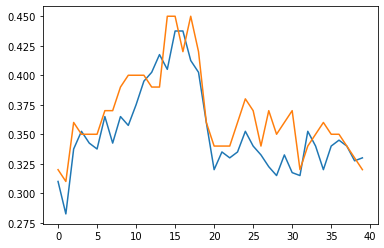

In [15]:
import matplotlib.pyplot as plt
print(val_acc)
plt.plot(train_acc)
plt.plot(val_acc)

## Training and Test Accuracy

## Training Accuracy

In [11]:
print(get_accuracy(train_testloader))

tensor([0.4375])


## Validation Accuracy

In [12]:
print(get_accuracy(testloader))

tensor([0.4700])


In [ ]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction_test.ndim == 1
assert prediction_test.shape[0] == 250

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (250, )
    assert loaded.dtype == int
    assert (loaded <= 4).all()
    assert (loaded >= 0).all()
validate_prediction_format()